# Assignment 1: Benchmarking Neural Nets with the XOR Problem

### **STUDENT**: Edward Anderson (eca4zm)

### DS 6050 - School of Data Science - University of Virginia
In this assignment, you will implement your own neural networks to classify non-linear data from the XOR dataset. For deliverables, you must write code in Python/Pytorch and submit **this** Jupyter Notebook file (.ipynb) to canvas to earn up to a total of 150 pts. Note that you must save your Notebook filename under this format: **yourUvaUserId_assignment_1_ann.ipynb**.

Updated: 01/06/2026 by Tom Hartvigsen.



In [1]:
# You might want to use the following packages
import numpy as np
import os
import torch
print(torch.__version__)
import torch.nn.functional as F
import torch.nn as nn

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from functools import partial

2.5.1


---
## 1. THE DATASET AND VISUALIZATION

We will use the non-linear toy data called the XOR dataset. You may use the code snippet below to generate the `train / validate / test` sets. Feel free to change the number of samples, and noise level. To keep the ratio between the sets consistent, please do not change the test_size and random_state parameters.



(720, 2)
(200, 2)
(80, 2)


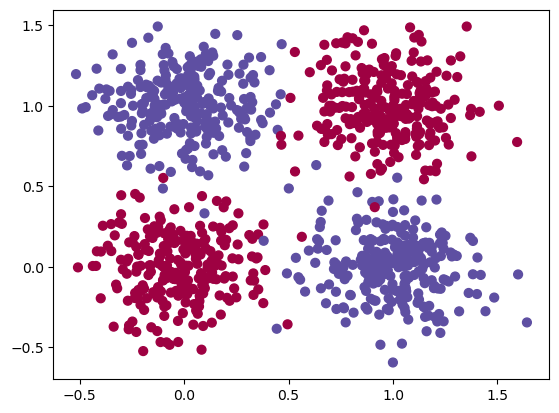

In [2]:
def make_xor(n_points):
    centers = np.array([[0,0],[0,1],[1,0],[1,1]])
    labels = np.array([0,1,1,0])
    data = np.array([]).reshape(-1,3)
    for center, label in zip(centers,labels):
        points = np.random.normal(loc=center,scale=0.2,size=(n_points//4,2))
        points_labels = np.hstack((points,label*np.ones(n_points//4).reshape((-1, 1))))
        data = np.vstack((data,points_labels))
    return (data[:,[0,1]],data[:,2])


X, y = make_xor(1000)
y=y.astype(np.int64)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=49)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size= 0.1, random_state=49)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)


---
## 2. TRAIN A SIMPLE ANN FOR CLASSIFICATION TASK

Use the standard libarary of Neural Net on the training data, and then test the classifier on the test data. You will create a simple ANN with 3 layers: an Input Layer, a Hidden Layer and an Output Layer. For each layer, you can specify the number of nodes appropriate for the XOR problem. Also, feel free to tune the network as you see fit. You have to report the accuracy of the network on the validation set.

In [3]:
class net(nn.Module):
  # Your code here!
  # TODO: implement a customized module using establised functions from pytorch
  # Loss can be calculated with nn.CrodsssEntropyLoss()
  # Linear layer could be added to the model with nn.linear()
  # Hyperbolic tangent can be achieved with torch.tanh()
  # Use any optimizer to optimize model parameters
  # An example can be found at: https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
  def __init__(self):
      super().__init__()
      self.flatten = nn.Flatten()
      self.linear_relu_stack = nn.Sequential(
          nn.Linear(2, 8),
          nn.Tanh(),
          nn.Linear(8, 1),
      )
  def forward(self, x):
      logits = self.linear_relu_stack(x)
      return logits
  
  pass

In [4]:
# Intialize model, loss function, optimizer
model = net()
learning_rate = 0.01   
epochs = 1000
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.BCEWithLogitsLoss()  

# tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Training loop
for epoch in range(epochs):
    model.train()
    logits = model(X_train_t)            
    loss = loss_fn(logits, y_train_t)        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Evaluation on test set
model.eval()
with torch.no_grad():
    logits = model(X_test_t)
    test_loss = loss_fn(logits, y_test_t)

    pred_class = (torch.sigmoid(logits) > 0.5).float() 
    accuracy = (pred_class == y_test_t).float().mean()

# Print results
print(f"Test loss: {test_loss.item():.4f}")
print(f"Accuracy: {accuracy*100:.1f}%")

Test loss: 0.0282
Accuracy: 99.0%


- - -
## 3. IMPLEMENTING YOUR OWN SIMPLE NEURAL NETWORK

Now that you see how the standard library ANN performs on the XOR dataset, you will attempt to implement your own version of the neural network. To help you, a template has been created including the backpropagation. Essensially, you will get the backward gradients for free. However, please note that the backprop implementation assume usage of tanh activation for the hidden layer and softmax for the output layer. There are some subtasks which you need to implement in order to get the network to work properly.

In [5]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import OneHotEncoder
import numpy as np

class MyNeuralNet(BaseEstimator):
    """Your implementation of a simple neural network"""

    def __init__ (self, n0, n1, n2, alpha=0.01):
        """
        @param: n0: Number of nodes in the input layer
        @param: n1: Number of nodes in the hidden layer
        @param: n2: Number of nodes in the output layer
        @param: alpha: The Learning Rate
        """

        # SUBTASK 1: Initialize the parameters to random values.
        np.random.seed(42)
        # Weight matrix 1 (n1 x n0)
        self.W1 = np.random.randn(n1, n0) * .01 # We multiply by small value to avoid large initial outputs
        # Bias Vector 1 (n1 x 1)
        self.b1 = np.zeros((n1, 1))
        # Weight Matrix 2 (n2 x n1)
        self.W2 = np.random.randn(n2, n1) * .01
        # Bias Vector 2 (n2 x 1)
        self.b2 = np.zeros((n2, 1))

        # Configure the learning rate
        self.alpha = alpha
        # One-hot encoder for labels
        self.encoder = OneHotEncoder(sparse_output=False)

    def forward_pass(self, X):
        """
        Pass the signal forward through the layers.
        @param: X: feature
        @return: A1: saved value of the output of the hidden layer
        @return: A2: activated return value of the output layer.
        """
        # SUBTASK 2: Implement Forward propagation.
        # Note: that you must implement tanh activation for the hiden layer
        # and softmax for the output layer
        

        Z1 = self.W1 @ X + self.b1 # This is the linear transformation of the input vector to hidden layer 1
        A1 = np.tanh(Z1) # Activation function for hidden layer 1
        Z2 = self.W2 @ A1 + self.b2 # Linear transformation from hidden layer 1 to output layer
        softmax = lambda x: (
            np.exp(x) / np.sum(np.exp(x), axis=0)
            )
        A2 = softmax(Z2) # Activation function for output layer

        return A1, A2


    def loss(self, X, y):
        """
        Evaluate the total loss on the dataset
        @param: X: features
        @param: y: labels
        @return: L: the loss value
        """
        # SUBTASK 3: Calculate the loss using Cross-Entropy
        # You will need to return the average loss on the data
        # Hint: Use A2 to calculate the loss
        A1, A2 = self.forward_pass(X)
        # Another Hint: First, you may want to convert the lable y into a one-hot vector
        Y = self.one_hot(y)
        # Loss
        m = y.shape[0]
        eps = 1e-15 # this is just to avoid log(0)
        cross_entropy_loss = lambda yhat, y: -1*np.sum(y * np.log(yhat + eps))
        L = cross_entropy_loss(A2, Y)/m
        return L

    def backward_pass(self, A1, A2, X, y): # GO OVER THIS WITH TOM...
        """
        @param: X: feature
        @param: y: label
        @param: A1: saved value of the output of the hidden layer
        @param: A2: activated return value of the output layer.

        @return: dW1: the loss gradient of W1
        @return: db1: the loss gradient of b1
        @return: dW2: the loss gradient of W2
        @return: db2: the loss gradient of b2
        """

        # unless you are advanced and want to use different activation function for your forward pass
        # This is an elegant partial derivative of cross entropy with softmax
        # Ref document: https://deepnotes.io/softmax-crossentropy
        # feel free to cross check the calculated gradients with autograd from Pytorch
        # Ref document: https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html
        m = y.shape[0]

        dZ2 = A2 - self.one_hot(y)
        dW2 = np.dot(dZ2, A1.T)/m
        db2 = np.sum(dZ2, axis=1, keepdims=True)/m
        dZ1 = np.multiply(np.dot(self.W2.T, dZ2), 1-np.power(A1, 2))
        dW1 = np.dot(dZ1, X.T)/m
        db1 = np.sum(dZ1, axis=1, keepdims=True)/m

        return dW1, db1, dW2, db2


    def fit(self, X, y , epochs, X_val, y_val):
        """
        Learns parameters for the neural network and returns the model.

        @param: X: the training feature
        @param: y: the train label
        @param: epochs: Number of passes through the training data for gradient descent
        @param: X_val: the feature of validation set
        @param: y_val: the label of validation set
        """

        # Input checks: X and X_val needs to be in the form of n0 x m
        if (X.shape[0] > X.shape[1]): 
            X = X.T
        if (X_val.shape[0] > X_val.shape[1]): 
            X_val = X_val.T

        # Gradient descent
        for i in range(0, epochs):
            # SUBTASK 4: Compute the forward, backward, and gradient descent parameter update
            # Step 1: Forward pass
            A1, A2 = self.forward_pass(X)

            # Step 2: Backward pass
            dW1, db1, dW2, db2 = self.backward_pass(A1, A2, X, y)

            # Step 3: Gradient Descent
            self.W1 = self.W1 - self.alpha * dW1
            self.b1 = self.b1 - self.alpha * db1
            self.W2 = self.W2 - self.alpha * dW2
            self.b2 = self.b2 - self.alpha * db2
            
            # Print the loss and validation accuracy every 10 epochs.
            if i % 10 == 0:
                print("Epoch %i/%i - loss: %f - accuracy: %f - val_loss: %f - val_accuracy: %f"
                      %(i,epochs, self.loss(X, y), self.evaluate(X, y),
                        self.loss(X_val, y_val), self.evaluate(X_val,y_val)))

    def predict(self, X):
        """
        Predict label vector y
        """
        # check X for the form of n0 x m
        if (X.shape[0] > X.shape[1]): 
            X = X.T

        # SUBTASK 5: Implement the prediction process.
        # Hint: It should include a forward pass, and then use the class with higher probability.
        # First Forward Pass
        _, A2 = self.forward_pass(X)
        # Choose the Max Value over the Rows (for each column)
        y_hat = np.argmax(A2, axis=0)
        
        return y_hat


    def evaluate(self, X, y):
        """
        Evaluate the accuracy of the model
        """
        m = y.shape[0]        
        y_hat = self.predict(X)
        # Check how many times the prediction is correct for each sample (m samples)
        correct_y = (y_hat == y).astype(int)

        return sum(correct_y)/m


    def one_hot(self, y):
        """
        Utility function: Convert a label vector to one-hot vector
        """
        Y = self.encoder.fit_transform(y.reshape(len(y),1))
        return Y.T # Transpose to get into same shape 1 x m


    def plot_decision_boundary(self, X, y):
        """
        Utility Function: Plot a decision boundary for visualization purpose.
        If you don't fully understand this function don't worry, it just generates the contour plot below.
        """
        # Set min and max values and give it some padding
        x_min, x_max = X[:,0].min() - .5, X[:,0].max() + .5
        y_min, y_max = X[:,1].min() - .5, X[:,1].max() + .5
        h = 0.01
        # Generate a grid of points with distance h between them
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        # Predict the function value for the whole gid
        data_grid= np.c_[xx.ravel(), yy.ravel()]
        Z = self.predict(data_grid)
        Z = Z.reshape(xx.shape)

        # Plot the contour and training examples
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)
        plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.Spectral)

---
## 4. REFLECT ON THE COMPARISON BETWEEN YOUR IMPLEMENTATION TO THE STANDARD LIBRARY
Now that you have implemented your own Neural Net class, let's use it! Create at least 3 instances of your Neural Net class, each with a different number of nodes in the hiden layer, tune it with the appropriate learning rate and number of iteration. You will test their performance in the Xor dataset and report the test accuracy metrics for each instance of your neural network.

Based on the test accuracy, compare your models with the standard library version.

In [6]:
print("DIMENSIONALITY:")
print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"X_val.shape: {X_val.shape}")
print(f"y_val.shape: {y_val.shape}")

DIMENSIONALITY:
X_train.shape: (720, 2)
y_train.shape: (720,)
X_val.shape: (80, 2)
y_val.shape: (80,)


Epoch 0/100 - loss: 0.693143 - accuracy: 0.513889 - val_loss: 0.693183 - val_accuracy: 0.412500
Epoch 10/100 - loss: 0.693107 - accuracy: 0.513889 - val_loss: 0.693420 - val_accuracy: 0.412500
Epoch 20/100 - loss: 0.693074 - accuracy: 0.513889 - val_loss: 0.693648 - val_accuracy: 0.412500
Epoch 30/100 - loss: 0.693044 - accuracy: 0.513889 - val_loss: 0.693866 - val_accuracy: 0.412500
Epoch 40/100 - loss: 0.693018 - accuracy: 0.513889 - val_loss: 0.694074 - val_accuracy: 0.412500
Epoch 50/100 - loss: 0.692993 - accuracy: 0.513889 - val_loss: 0.694274 - val_accuracy: 0.412500
Epoch 60/100 - loss: 0.692971 - accuracy: 0.513889 - val_loss: 0.694465 - val_accuracy: 0.412500
Epoch 70/100 - loss: 0.692951 - accuracy: 0.513889 - val_loss: 0.694647 - val_accuracy: 0.412500
Epoch 80/100 - loss: 0.692933 - accuracy: 0.513889 - val_loss: 0.694822 - val_accuracy: 0.412500
Epoch 90/100 - loss: 0.692917 - accuracy: 0.513889 - val_loss: 0.694989 - val_accuracy: 0.412500
Accuracy on the test set is  0.

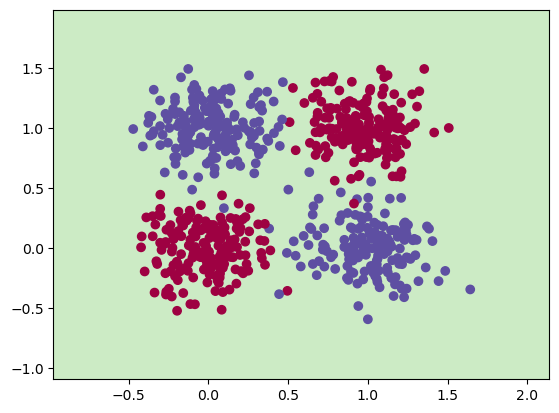

In [7]:
# MODEL 1 here
n0 = 2 # input layer dimensionality
n1 = 8 # hiden layer dimensionality
n2 = 2 # output layer dimensionality
alpha = 0.01 # learning rate for gradient descent
epochs = 100 # number of iteration/epochs

# Build a model with 3 layers
myModel1 = MyNeuralNet(n0, n1, n2, alpha)
myModel1.fit(X_train, y_train, epochs, X_val, y_val)
print("Accuracy on the test set is ", myModel1.evaluate(X_test, y_test))

# Plot the decision boundary
myModel1.plot_decision_boundary(X_train, y_train)

Accuracy of Model 1 is only .48. This is basically guessing... Perhaps epoch is too low and learning rate too small. 

Epoch 0/10000 - loss: 0.693110 - accuracy: 0.513889 - val_loss: 0.693403 - val_accuracy: 0.412500
Epoch 10/10000 - loss: 0.692887 - accuracy: 0.513889 - val_loss: 0.695324 - val_accuracy: 0.412500
Epoch 20/10000 - loss: 0.692807 - accuracy: 0.513889 - val_loss: 0.696527 - val_accuracy: 0.412500
Epoch 30/10000 - loss: 0.692778 - accuracy: 0.513889 - val_loss: 0.697266 - val_accuracy: 0.412500
Epoch 40/10000 - loss: 0.692767 - accuracy: 0.513889 - val_loss: 0.697715 - val_accuracy: 0.412500
Epoch 50/10000 - loss: 0.692763 - accuracy: 0.513889 - val_loss: 0.697986 - val_accuracy: 0.412500
Epoch 60/10000 - loss: 0.692762 - accuracy: 0.513889 - val_loss: 0.698150 - val_accuracy: 0.412500
Epoch 70/10000 - loss: 0.692761 - accuracy: 0.513889 - val_loss: 0.698248 - val_accuracy: 0.412500
Epoch 80/10000 - loss: 0.692760 - accuracy: 0.513889 - val_loss: 0.698307 - val_accuracy: 0.412500
Epoch 90/10000 - loss: 0.692759 - accuracy: 0.513889 - val_loss: 0.698343 - val_accuracy: 0.412500
Epoch 100/1

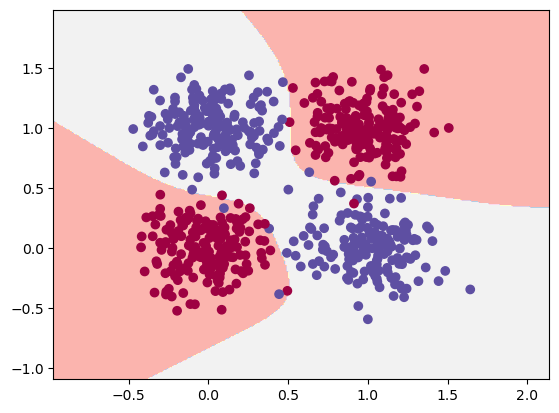

In [17]:
# MODEL 2 here
n0 = 2 # Unchanged
n1 = 8
n2 = 2 # Unchanged
alpha = 0.1
epochs = 10000

# Build a model with 3 layers
myModel2 = MyNeuralNet(n0, n1, n2, alpha)
myModel2.fit(X_train, y_train, epochs, X_val, y_val)
print("Accuracy on the test set is ", myModel2.evaluate(X_test, y_test))

# Plot the decision boundary
myModel2.plot_decision_boundary(X_train, y_train)

With **10,000** epochs and a learning rate of **.1**, the model performed MUCH better with **98%** accuracy. Next I will try adjusting the hidden layer dimensionality.

Epoch 0/10000 - loss: 0.693110 - accuracy: 0.513889 - val_loss: 0.693402 - val_accuracy: 0.412500
Epoch 10/10000 - loss: 0.692888 - accuracy: 0.513889 - val_loss: 0.695321 - val_accuracy: 0.412500
Epoch 20/10000 - loss: 0.692808 - accuracy: 0.513889 - val_loss: 0.696523 - val_accuracy: 0.412500
Epoch 30/10000 - loss: 0.692780 - accuracy: 0.513889 - val_loss: 0.697263 - val_accuracy: 0.412500
Epoch 40/10000 - loss: 0.692769 - accuracy: 0.513889 - val_loss: 0.697712 - val_accuracy: 0.412500
Epoch 50/10000 - loss: 0.692765 - accuracy: 0.513889 - val_loss: 0.697984 - val_accuracy: 0.412500
Epoch 60/10000 - loss: 0.692764 - accuracy: 0.513889 - val_loss: 0.698147 - val_accuracy: 0.412500
Epoch 70/10000 - loss: 0.692763 - accuracy: 0.513889 - val_loss: 0.698246 - val_accuracy: 0.412500
Epoch 80/10000 - loss: 0.692763 - accuracy: 0.513889 - val_loss: 0.698305 - val_accuracy: 0.412500
Epoch 90/10000 - loss: 0.692763 - accuracy: 0.513889 - val_loss: 0.698340 - val_accuracy: 0.412500
Epoch 100/1

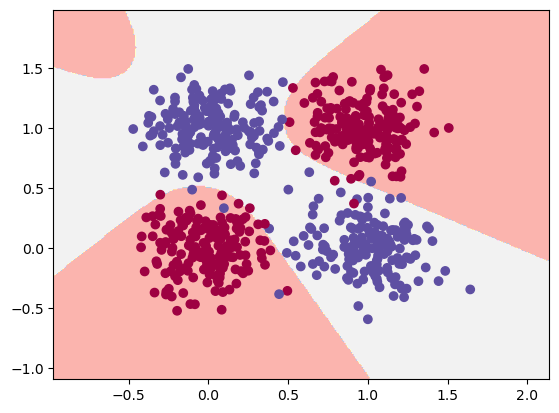

In [24]:
# MODEL 3 here
n0 = 2 # Unchanged
n1 = 3
n2 = 2 # Unchanged
alpha = 0.1
epochs = 10000

# Build a model with 3 layers
myModel3 = MyNeuralNet(n0, n1, n2, alpha)
myModel3.fit(X_train, y_train, epochs, X_val, y_val)
print("Accuracy on the test set is ", myModel3.evaluate(X_test, y_test))

# Plot the decision boundary
myModel3.plot_decision_boundary(X_train, y_train)

It appears that the minimum number of nodes in the hidden layer to solve the XOR problem in this case is 2, but 3 solves the problem with might accuracy and stability. In this case, I would say that 3 is the minimum reccomended number of nodes in the hidden layer. 

In [27]:
# COMPARISONS OF THESE MODELS WITH THE STANDARD LIBRARY MODEL IN TASK 2
print("PyTorch Model Loss and Accuracy: ")
print(f"Test loss: {test_loss.item():.4f}")
print(f"Accuracy: {accuracy*100:.1f}%")

PyTorch Model Loss and Accuracy: 
Test loss: 0.0282
Accuracy: 99.0%


## Reflection
Write at least a paragraph answering these prompts: How did your own network perform? Is there any major differences between the implementations? Finally, reflecting on your experience implementing a learning algorithm for this assignment (Was it hard/easy/fun?, From which part did you learn the most?)!

I was able to achieve similar accuracy with my numpy implemented artificial neural network (awesome!) but the pytorch model was more efficient and easier to implement. My model required a much higher learning rate of .1 to achieve 98% accuracy while the pytorch model achieved similar accuracy (99%) with a smaller learning rate of .01. Moreover, my implementation required a much larger number of epochs (10,000) to achieve 98% accuracy while the PyTorch model required only 1,000 epochs to achieve 99% accuracy. My suspicion is that this is due to the ADAM optimizer used in the PyTorch model. ADAM is more efficient that the standard gradient descent that I implemented in my numpy model. I would say that this optimizer is one of the only major differences between the two implementations.

I found this assignment to be super interesting and a fun way to deepen my understanding of neural networks. I found the numpy implementation particuilarly interesting and challenging (in a good way); it helped me gain a foundational understanding of what is happening behind the hood of all the PyTorch functions and was very useful to see how the model fits together. I found it fun and rewarding to solve the XOR problem from scratch, without using any of the standard deep learning libraries. For me, following the dimensionality of the matrices and vectors (and what they represent) throughout the model was challenging. Overall, I learned a lot from this assignment and found it to be very rewarding!

---
# Get Help?
In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my lecture slides on Module 1.
 * Post a question on Discord.
 * Talk to the TA, they are available and there to help you during office hour.
 * Come talk to me or, if essential, email me <hartvigsen@virginia.edu> with subject starting "[DS 6050 Assignment 1]:...".

Part of the codes used in this assignment is modified from Konstantinos Kitsios under the 3-Clause BSD License. Best of luck and have fun!